Used metrics:
t(threshold)
AP(Average Precision)
mIOU(mean IOU)
IOUfg(Foreground IOU only)

In [1]:
import torch
import torchmetrics
import torchvision.transforms as transforms
from PIL import Image

c:\Users\yitao\.conda\envs\test\Lib\site-packages\torchaudio\backend\utils.py:74: UserWarning: No audio backend is available.
  warnings.warn("No audio backend is available.")


In [2]:
# get image id and its name
METAFILE_DIR = "./dataset/metafiles/"

with open(METAFILE_DIR + "images.txt", "r") as f:
    lines = f.readlines()

img_names = []
for line in lines:
    parts = line.strip().split(" ")
    img_names.append(parts[1])

f.close()

In [3]:
# Load ground truth
MASKS_PATH = "./dataset/masks/"
GT_PATH = MASKS_PATH + "gt/"
CLIP_PATH = MASKS_PATH + "clipseg/"
DSS_PATH = MASKS_PATH + "dss/"

In [5]:
def toBinary(pred):
    one = torch.ones_like(pred)
    zero = torch.zeros_like(pred)
    pred_bi = torch.where(pred > 0, one, zero)
    return pred_bi

torch.Size([683, 1024])
torch.Size([683, 1024])


C:\Users\yitao\AppData\Local\Temp\ipykernel_13376\739327256.py:22: MatplotlibDeprecationWarning: Auto-removal of overlapping axes is deprecated since 3.6 and will be removed two minor releases later; explicitly call ax.remove() as needed.
  plt.subplot(2, 3, 1)


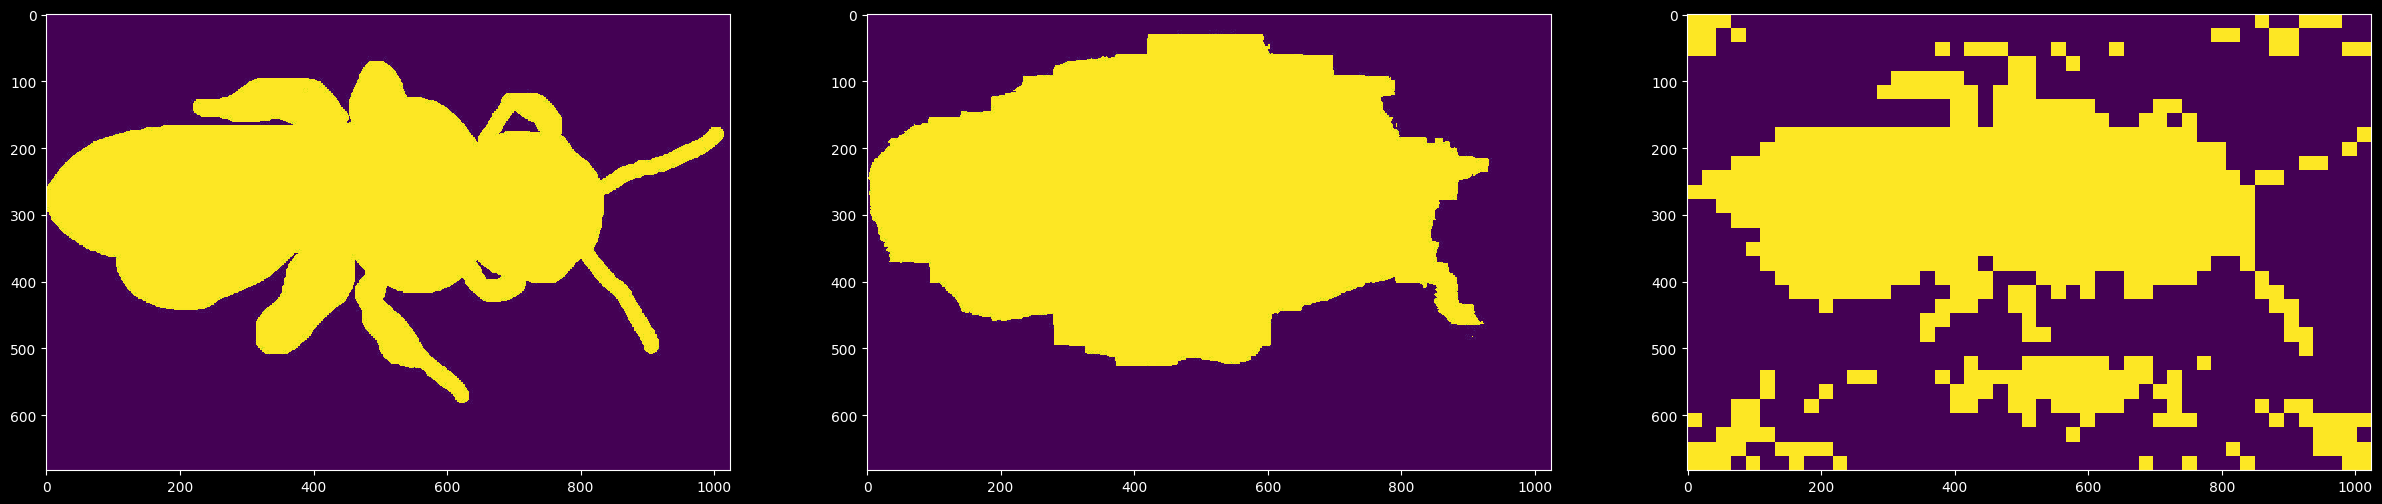

IOU_clipseg: 74.36%
IOU_dss: 64.54%


In [6]:
import matplotlib.pyplot as plt
from myutils.img_loader import get_img_by_id

id = 300
img_origin = get_img_by_id(id)
img_gt = Image.open(GT_PATH + img_names[id - 1])
img_clip = Image.open(CLIP_PATH + "0.3/" + img_names[id - 1])
img_dss = Image.open("./dataset/test/test.png")

toTensor = transforms.ToTensor()
mask_gt = toTensor(img_gt).squeeze(0)
mask_clip = toTensor(img_clip).squeeze(0)
mask_dss = toTensor(img_dss).squeeze(0)

print(mask_gt.shape)
print(mask_clip.shape)

plt.figure(figsize=(30, 20))

plt.subplot(1, 3, 1)
plt.imshow(img_origin)
plt.subplot(2, 3, 1)
plt.imshow(mask_gt, interpolation="none")
plt.subplot(2, 3, 2)
plt.imshow(mask_clip, interpolation="none")
plt.subplot(2, 3, 3)
plt.imshow(mask_dss, interpolation="none")

plt.show()

from torchmetrics.classification import BinaryJaccardIndex

mask_gt = toBinary(toTensor(img_gt).squeeze(0))
mask_clip = toBinary(toTensor(img_clip).squeeze(0))
mask_dss = toBinary(toTensor(img_dss).squeeze(0))
metric = BinaryJaccardIndex()
print("IOU_clipseg: " + str(round(metric(mask_clip, mask_gt).item() * 100, 2)) + "%")
print("IOU_dss: " + str(round(metric(mask_dss, mask_gt).item() * 100, 2)) + "%")

C:\Users\yitao\AppData\Local\Temp\ipykernel_12724\2687505132.py:18: MatplotlibDeprecationWarning: Auto-removal of overlapping axes is deprecated since 3.6 and will be removed two minor releases later; explicitly call ax.remove() as needed.
  plt.subplot(2, 3, 1)


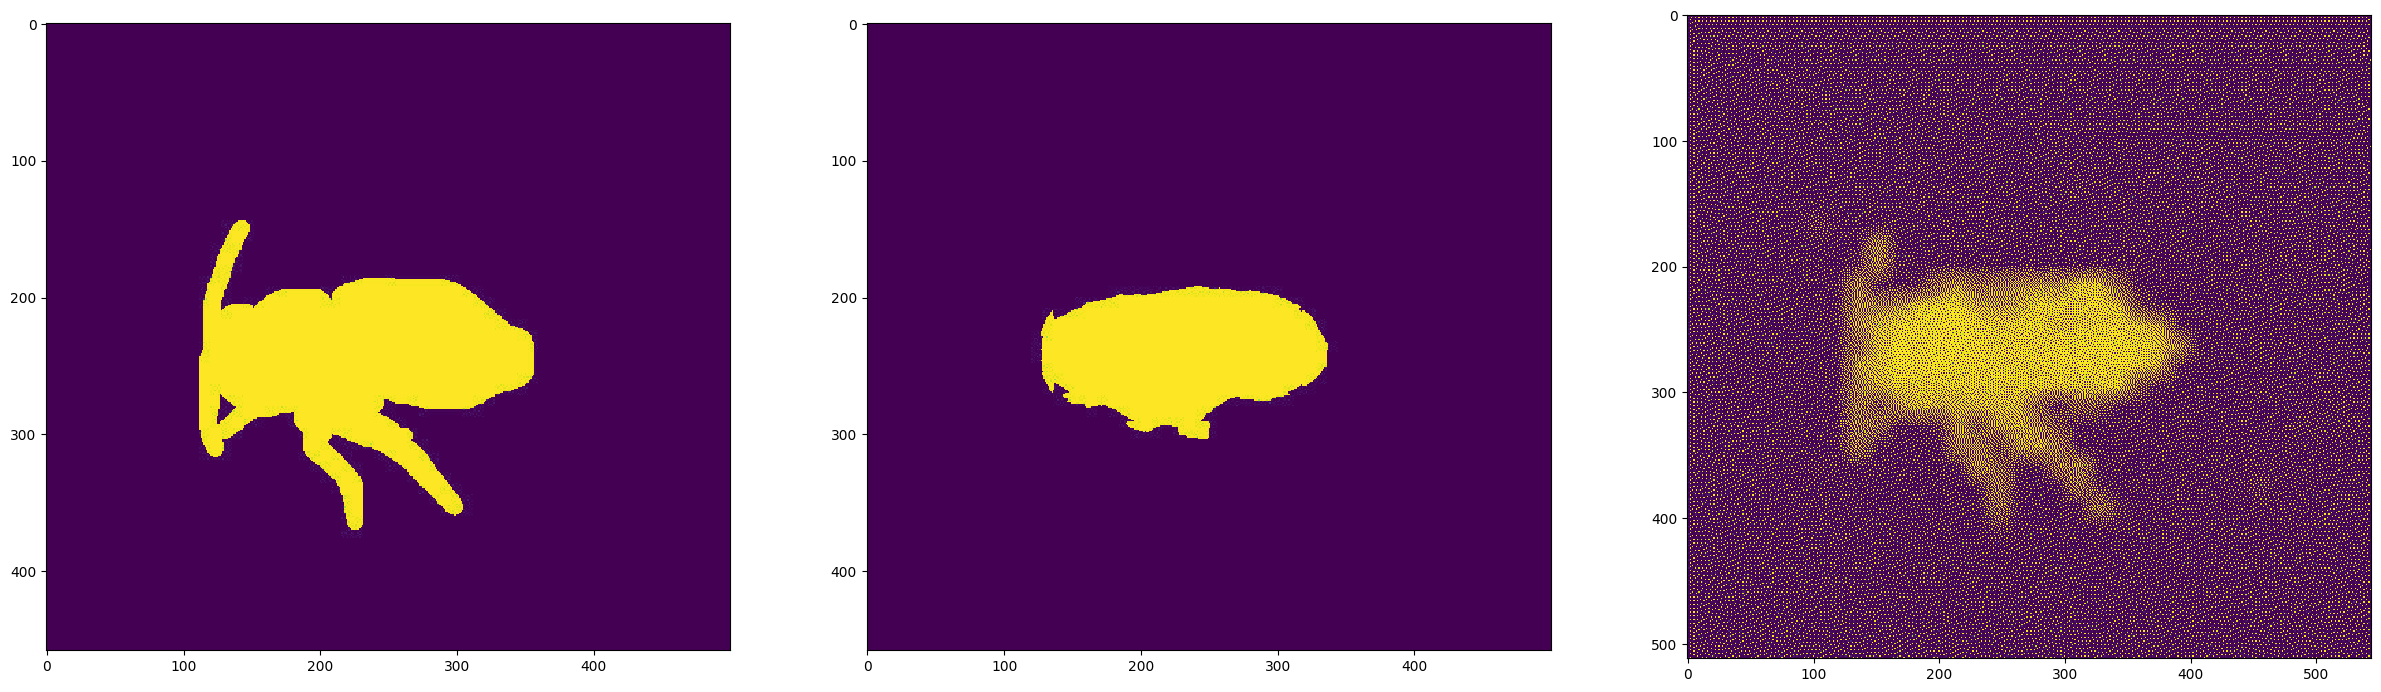

IOU_clipseg: 62.39%


RuntimeError: Predictions and targets are expected to have the same shape, but got torch.Size([512, 544]) and torch.Size([458, 500]).

In [36]:
import matplotlib.pyplot as plt

id = 5
img_origin = plt.imread("./dataset/WildBees/" + img_names[id - 1])
img_gt = Image.open(GT_PATH + img_names[id - 1])
img_clip = Image.open(CLIP_PATH + "0.3/" + img_names[id - 1])
img_dss = Image.open(DSS_PATH + "0.3/" + img_names[id - 1])

toTensor = transforms.ToTensor()
mask_gt = toTensor(img_gt).squeeze(0)
mask_clip = toTensor(img_clip).squeeze(0)
mask_dss = toTensor(img_dss).squeeze(0)

plt.figure(figsize=(30, 20))

plt.subplot(1, 3, 1)
plt.imshow(img_origin)
plt.subplot(2, 3, 1)
plt.imshow(mask_gt, interpolation="none")
plt.subplot(2, 3, 2)
plt.imshow(mask_clip, interpolation="none")
plt.subplot(2, 3, 3)
plt.imshow(mask_dss, interpolation="none")

plt.show()

from torchmetrics.classification import BinaryJaccardIndex

mask_gt = toBinary(toTensor(img_gt).squeeze(0))
mask_clip = toBinary(toTensor(img_clip).squeeze(0))
mask_dss = toBinary(toTensor(img_dss).squeeze(0))
metric = BinaryJaccardIndex()
print("IOU_clipseg: " + str(round(metric(mask_clip, mask_gt).item() * 100, 2)) + "%")
print("IOU_dss: " + str(round(metric(mask_dss, mask_gt).item() * 100, 2)) + "%")

In [32]:
# calculate overall IOU for CLIPSEG

metric = BinaryJaccardIndex()

thresholds = [0.2, 0.25, 0.3, 0.35, 0.4, 0.5]
overall_ious = []

print("OVERALL IOUs: ")
for t in thresholds:
    ious = []
    for i in range(len(img_names)):
        img_gt = Image.open(GT_PATH + img_names[i])
        img_clip = Image.open(CLIP_PATH + str(t) + "/" + img_names[i])
        mask_gt = toBinary(toTensor(img_gt).squeeze(0))
        mask_clip = toBinary(toTensor(img_clip).squeeze(0))
        iou = round(metric(mask_clip, mask_gt).item() * 100, 2)
        ious.append(iou)

    overall_iou = round(sum(ious) / len(ious), 2)
    overall_ious.append(overall_iou)
    print("threshold = " + str(t) + ": overall IOU = " + str(overall_iou))

OVERALL IOUs: 
threshold = 0.2: overall IOU = 59.44
threshold = 0.25: overall IOU = 56.25
threshold = 0.3: overall IOU = 52.53
threshold = 0.35: overall IOU = 48.64
threshold = 0.4: overall IOU = 44.33


RuntimeError: Predictions and targets are expected to have the same shape, but got torch.Size([512, 512]) and torch.Size([1024, 1024]).

In [41]:
from torchmetrics.classification import BinaryAveragePrecision

# calculate overall Binary AP for CLIPSEG

metric_biAP = BinaryAveragePrecision(thresholds=None)

thresholds = [0.2, 0.25, 0.3, 0.35, 0.4, 0.5]
overall_biaps = []

print("OVERALL binary APs: ")
for t in thresholds:
    biaps = []
    for i in range(len(img_names)):
        img_gt = Image.open(GT_PATH + img_names[i])
        img_clip = Image.open(CLIP_PATH + str(t) + "/" + img_names[i])
        mask_gt = toBinary(toTensor(img_gt).squeeze(0))
        mask_clip = toBinary(toTensor(img_clip).squeeze(0))
        biap = round(metric_biAP(mask_clip, mask_gt).item() * 100, 2)
        biaps.append(biap)

    overall_biap = round(sum(ious) / len(ious), 2)
    overall_biaps.append(overall_biap)
    print("threshold(" + str(t) + ") | overall binay AP = " + str(overall_biap))

OVERALL binay APs: 


ValueError: Expected argument `target` to be an int or long tensor with ground truth labels but got tensor with dtype torch.float32

In [33]:
# calculate overall IOU for DEEP_SPECTRAL_SEGMENTATION


metric = BinaryJaccardIndex()

thresholds = [0.2, 0.25, 0.3, 0.35, 0.4, 0.45, 0.5]
overall_ious = []

print("OVERALL IOUs: ")
for t in thresholds:
    ious = []
    for i in range(len(img_names)):
        img_gt = Image.open(GT_PATH + img_names[i])
        img_dss = Image.open(DSS_PATH + str(t) + "/" + img_names[i])
        mask_gt = toBinary(toTensor(img_gt).squeeze(0))
        mask_dss = toBinary(toTensor(img_dss).squeeze(0))
        iou = round(metric(mask_dss, mask_gt).item() * 100, 2)
        ious.append(iou)

    overall_iou = round(sum(ious) / len(ious), 2)
    overall_ious.append(overall_iou)
    print("threshold = " + str(t) + ": overall IOU = " + str(overall_iou))

OVERALL IOUs: 


RuntimeError: Predictions and targets are expected to have the same shape, but got torch.Size([512, 512]) and torch.Size([1024, 1024]).